# English to French Seq2Seq Bidirectional LSTM with attention

Much of the code (for data processing, visualization and other helper functions) taken from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

Data file: https://download.pytorch.org/tutorial/data.zip

In [21]:
from __future__ import unicode_literals, print_function, division

import torch
import pandas as pd
import numpy as np
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from io import open
import unicodedata
import string
import re
import random
import os
from torch import optim

plt.switch_backend('agg')
%matplotlib inline

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Encoder Model

Bidirectional LSTM with an embedding layer.

Hidden state: tuple of two tensors (hidden state and memory).

In [3]:
class EncoderRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, num_layers=1,
               dropout=0, bidirectional=True):
    super(EncoderRNN, self).__init__()
    self.n_hidden = n_hidden
    self.n_inputs = n_inputs
    self.bidirectional = bidirectional
    
    self.embedding = nn.Embedding(n_inputs, n_hidden)
    self.lstm = nn.LSTM(n_hidden, n_hidden, num_layers,
                        dropout=dropout, bidirectional=bidirectional)
    
  def forward(self, input, hidden):
    input = self.embedding(input).view(1, 1, self.n_hidden)
    output, hidden = self.lstm(input, hidden)
    return output, hidden
  
  def init_hidden(self):
    return (torch.zeros(1 + int(self.bidirectional), 1, self.n_hidden).to(device),
            torch.zeros(1 + int(self.bidirectional), 1, self.n_hidden).to(device))
#     can also do
#     return (torch.zeros(1 + int(self.bidirectional), 1, self.n_hidden // 2).to(device),
#             torch.zeros(1 + int(self.bidirectional), 1, self.n_hidden // 2).to(device))

### Decoder Model

Unidirectional LSTM with attention.

each hidden state size of decoder twice that of encoder (as encoder is bidirectional).

Initial decoder hidden state = final encoder hidden state (Done later in training).

Attention weight calculated using a Linear(n_hidden\*4,1) network.

Final layer input: n_hidden\*6
- n_hidden\*2 : attn_applied
                +
- n_hidden\*4 : decoder hidden state


#### Flow
- Extract embedding from input.
- Pass embedding, hidden to lstm to obtain output and new hidden state
- For encoder output from each timestep, pass concatenated encoder_output and decoder hidden state through attn to obtain attention scores. attn_scores same number of elements as encoder hidden states
- Softmax attention scores to get attention weights (attn_distribution).
- The applied attention (attn_applied) is weighted vector of encoder outputs where the weights are attn_distribution.
- Concatenate attn_applied with decoder hidden state and pass through fully connected output layer and softmax to get probability distribution of next word.

For reference, see: https://www.youtube.com/watch?v=XXtpJxZBa2c

In [4]:
class AttnDecoderRNN(nn.Module):
  #Decoder always unidirectional
  def __init__(self, n_hidden, n_outputs, num_layers=1, dropout=0):
    super(AttnDecoderRNN, self).__init__()
    print(n_hidden)
    self.n_hidden = n_hidden
    self.n_outputs = n_outputs

    self.embedding = nn.Embedding(n_outputs, n_hidden)
    self.attn = nn.Linear(n_hidden*4, 1)
    self.lstm = nn.LSTM(n_hidden, n_hidden*2, num_layers, dropout=dropout)
    self.out = nn.Linear(n_hidden*6, n_outputs)

  def forward(self, input, hidden, encoder_outputs):
    input = self.embedding(input).view(1,1,self.n_hidden)
    
    hidden = tuple(h.view(1,1,-1) for h in hidden)
    #concat hidden state of forward and backward
    #encoder LSTM (2,1,256)->(1,1,512)
    #can be moved outside this function
    #only need to be executed for first
    #decoder timestep
    
    output, hidden = self.lstm(input, hidden)

    attn_scores = []
    for encoder_output in encoder_outputs:
      temp = torch.cat((hidden[0][0], encoder_output.view(1,-1)),1)
      attn_scores.append(self.attn(temp))

    attn_distribution = F.softmax(torch.cat(attn_scores, 1), 1)
    attn_applied = torch.bmm(attn_distribution.unsqueeze(1),
                             encoder_outputs.view(1, -1, self.n_hidden*2))
    
    hidden_tensor = torch.stack(hidden).view((1,-1))
    #convert tuple to tensor
    
    attn_applied = attn_applied.view((1,-1))
    z = torch.cat((attn_applied, hidden_tensor),1)

    output = F.log_softmax(self.out(z),dim=1)

    return output, hidden, attn_distribution

In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('./%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je ne lui suis pas lie .', 'i am not acquainted with him .']


In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.n_hidden*2, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        # print(encoder_outputs.size(), encoder_output.size())
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # print(decoder_output.size(), target_tensor[di].size())
            # print(target_tensor[di], target_tensor[di].dtype)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input


            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [11]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [12]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.n_hidden*2, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [13]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [16]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

256


In [21]:
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

256
3m 50s (- 53m 50s) (5000 6%) 2.7930
7m 41s (- 49m 57s) (10000 13%) 2.2892
11m 32s (- 46m 11s) (15000 20%) 1.9904
15m 28s (- 42m 34s) (20000 26%) 1.7426
19m 23s (- 38m 47s) (25000 33%) 1.5342
23m 15s (- 34m 52s) (30000 40%) 1.2865
27m 8s (- 31m 1s) (35000 46%) 1.1320
31m 3s (- 27m 10s) (40000 53%) 0.9453
34m 56s (- 23m 17s) (45000 60%) 0.8341
38m 52s (- 19m 26s) (50000 66%) 0.7135
42m 47s (- 15m 33s) (55000 73%) 0.6119
46m 44s (- 11m 41s) (60000 80%) 0.5278
50m 39s (- 7m 47s) (65000 86%) 0.4477
54m 36s (- 3m 54s) (70000 93%) 0.4199
58m 34s (- 0m 0s) (75000 100%) 0.3636


## Inference

#### Use CPU for inference

In [17]:
device = torch.device("cpu")

In [19]:
encoder1.load_state_dict(torch.load('./models/encoder.pth'))
encoder1.to(device)
attn_decoder1.load_state_dict(torch.load('./models/decoder.pth'))
attn_decoder1.to(device)

AttnDecoderRNN(
  (embedding): Embedding(2803, 256)
  (attn): Linear(in_features=1024, out_features=1, bias=True)
  (lstm): LSTM(256, 512)
  (out): Linear(in_features=1536, out_features=2803, bias=True)
)

## Random Evaluation

### Format:

\> [french input]

= [actual english translation]

< [predicted english translation]

In [20]:
evaluateRandomly(encoder1, attn_decoder1)

> tu es grognon .
= you re grumpy .
< you re grumpy . <EOS>

> j en ai assez de me disputer .
= i m tired of arguing .
< i m tired of arguing . <EOS>

> vous vous comportez comme une enfant .
= you re acting like a child .
< you re acting like a child . <EOS>

> tu es tatillonne .
= you re finicky .
< you re finicky . <EOS>

> je ne suis pas embarrasse .
= i m not embarrassed .
< i m not embarrassed . <EOS>

> il est incroyablement talentueux .
= he s incredibly talented .
< he s incredibly talented . <EOS>

> je me rejouis que vous soyez venue .
= i m glad you came over .
< i m glad you came over . <EOS>

> ils sont en salle des professeurs .
= they are in the teachers room .
< they are in the teachers room . <EOS>

> vous etes productif .
= you re productive .
< you re productive . <EOS>

> je serai ton maitre .
= i m going to be your teacher .
< i m going to be your teacher . <EOS>



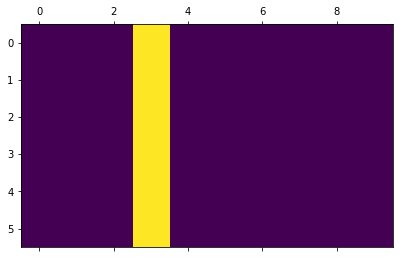

In [22]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


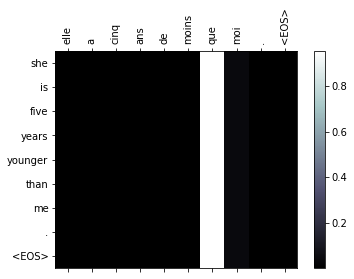

input = elle est trop petit .
output = she s too short . <EOS>


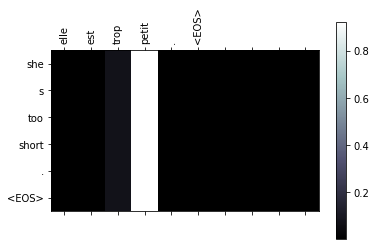

input = je ne crains pas de mourir .
output = i am not scared of dying . <EOS>


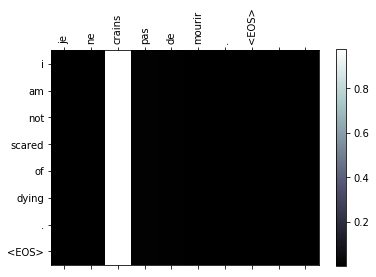

input = c est un jeune directeur plein de talent .
output = he s a talented young director . <EOS>


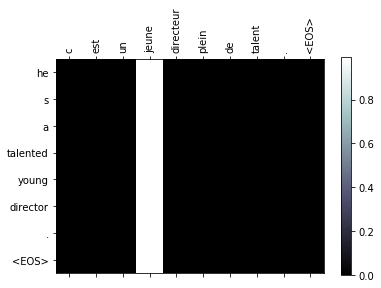

In [23]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")